In [293]:
import numpy as np
import pandas as pd
import math
import random
import tensorflow as tf
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# **Eksplorasi data**

In [294]:
df_AAPL = pd.read_csv("AAPL.csv", usecols=['Date', 'Close'])
df_AMD  = pd.read_csv("AMD.csv", usecols=['Date', 'Close'])
print(df_AAPL.head())
print(df_AMD.head())

         Date     Close
0  1980-12-12  0.513393
1  1980-12-15  0.486607
2  1980-12-16  0.450893
3  1980-12-17  0.462054
4  1980-12-18  0.475446
         Date     Close
0  1980-03-17  3.145833
1  1980-03-18  3.031250
2  1980-03-19  3.041667
3  1980-03-20  3.010417
4  1980-03-21  2.916667


In [295]:
print(df_AAPL.info())
print(df_AMD.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9909 non-null   object 
 1   Close   9909 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10098 entries, 0 to 10097
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10098 non-null  object 
 1   Close   10098 non-null  float64
dtypes: float64(1), object(1)
memory usage: 157.9+ KB
None


In [296]:
print(df_AAPL.isnull().sum())
print(df_AMD.isnull().sum())

Date     0
Close    0
dtype: int64
Date     0
Close    0
dtype: int64


In [297]:
uni_data_AAPL = df_AAPL['Close']
uni_data_AAPL.index = df_AAPL['Date']

uni_data_AMD = df_AMD['Close']
uni_data_AMD.index = df_AMD['Date']

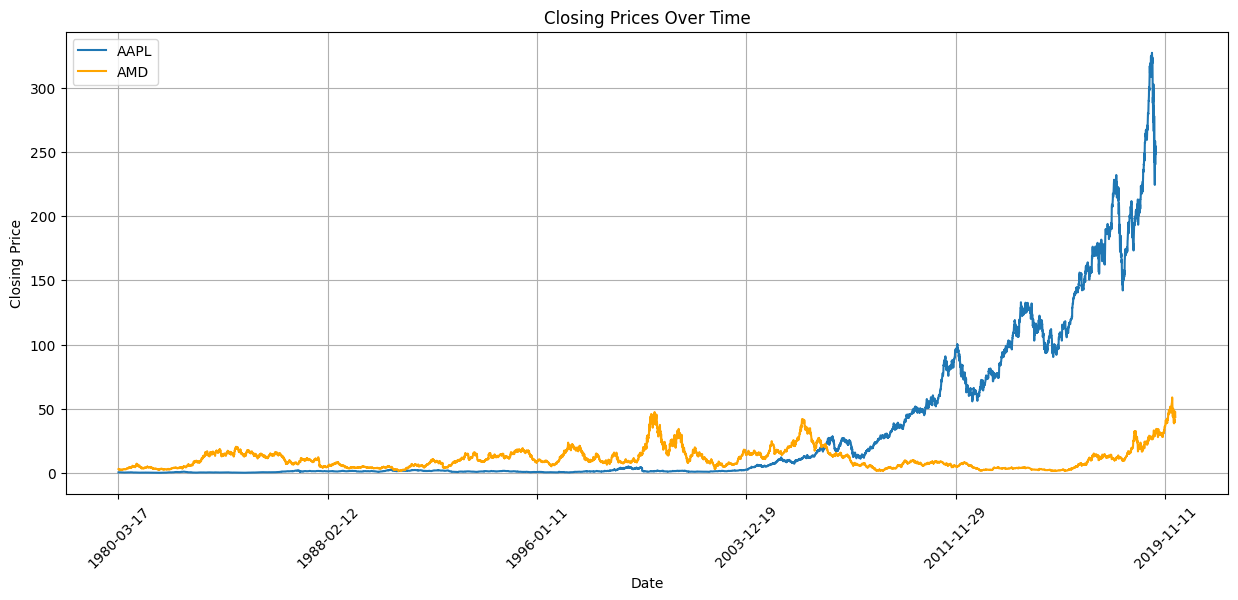

In [298]:
plt.figure(figsize=(15, 6))
uni_data_AAPL.plot(subplots=True, label="AAPL") 
uni_data_AMD.plot(subplots=True, label="AMD", color="orange") 
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation = 45)
plt.grid(True)
plt.legend()
plt.show()

In [299]:
def create_time_series(data, window_size=5, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

window_size = 5
horizon = 1

x_AAPL, y_AAPL = create_time_series(uni_data_AAPL, window_size=5, horizon=1)
x_AMD, y_AMD = create_time_series(uni_data_AMD, window_size=5, horizon=1)

## Splitting

In [300]:
TRAIN_SPLIT = int(len(x_AAPL) * 0.8)
VAL_SPLIT = int(len(x_AAPL) * 0.9)

x_train_AAPL, y_train_AAPL = x_AAPL[:TRAIN_SPLIT], y_AAPL[:TRAIN_SPLIT]
x_val_AAPL, y_val_AAPL = x_AAPL[TRAIN_SPLIT:VAL_SPLIT], y_AAPL[TRAIN_SPLIT:VAL_SPLIT]
x_test_AAPL, y_test_AAPL = x_AAPL[VAL_SPLIT:], y_AAPL[VAL_SPLIT:]

x_train_AMD, y_train_AMD = x_AMD[:TRAIN_SPLIT], y_AMD[:TRAIN_SPLIT]
x_val_AMD, y_val_AMD = x_AMD[TRAIN_SPLIT:VAL_SPLIT], y_AMD[TRAIN_SPLIT:VAL_SPLIT]
x_test_AMD, y_test_AMD = x_AMD[VAL_SPLIT:], y_AMD[VAL_SPLIT:]

In [301]:
scaler = MinMaxScaler()
y_train_AAPL = scaler.fit_transform(y_train_AAPL.reshape(-1,1))
y_val_AAPL = scaler.transform(y_val_AAPL.reshape(-1,1))
y_test_AAPL = scaler.transform(y_test_AAPL.reshape(-1,1))

y_train_AMD = scaler.fit_transform(y_train_AMD.reshape(-1,1))
y_val_AMD = scaler.transform(y_val_AMD.reshape(-1,1))
y_test_AMD = scaler.transform(y_test_AMD.reshape(-1,1))

In [302]:
print(y_train_AAPL)
print(y_train_AMD)

[[0.00339644]
 [0.00366718]
 [0.0039133 ]
 ...
 [0.87712153]
 [0.86916697]
 [0.85799908]]
[[0.01896426]
 [0.01759665]
 [0.01417761]
 ...
 [0.09649891]
 [0.10131291]
 [0.09934355]]


In [303]:
for i in range(window_size):
    x_train_AAPL[:,i] = scaler.transform(x_train_AAPL[:,i].reshape(-1, 1)).reshape(-1)
    x_val_AAPL[:,i] = scaler.transform(x_val_AAPL[:,i].reshape(-1, 1)).reshape(-1)
    x_test_AAPL[:,i] = scaler.transform(x_test_AAPL[:,i].reshape(-1, 1)).reshape(-1)

for i in range(window_size):
    x_train_AMD[:,i] = scaler.transform(x_train_AMD[:,i].reshape(-1, 1)).reshape(-1)
    x_val_AMD[:,i] = scaler.transform(x_val_AMD[:,i].reshape(-1, 1)).reshape(-1)
    x_test_AMD[:,i] = scaler.transform(x_test_AMD[:,i].reshape(-1, 1)).reshape(-1)

In [304]:
print(x_train_AAPL[0])
print(x_train_AMD[0])

[-0.02815333 -0.02873945 -0.02952094 -0.02927673 -0.02898367]
[0.02944931 0.02694201 0.02716995 0.02648614 0.02443472]


In [305]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_univariate_AAPL = tf.data.Dataset.from_tensor_slices((x_train_AAPL, y_train_AAPL))
train_univariate_AAPL = train_univariate_AAPL.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate_AAPL = tf.data.Dataset.from_tensor_slices((x_val_AAPL, y_val_AAPL))
val_univariate_AAPL = val_univariate_AAPL.batch(BATCH_SIZE)

test_univariate_AAPL = tf.data.Dataset.from_tensor_slices((x_test_AAPL, y_test_AAPL))
test_univariate_AAPL = test_univariate_AAPL.batch(BATCH_SIZE)

train_univariate_AMD = tf.data.Dataset.from_tensor_slices((x_train_AMD, y_train_AMD))
train_univariate_AMD = train_univariate_AMD.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate_AMD = tf.data.Dataset.from_tensor_slices((x_val_AMD, y_val_AMD))
val_univariate_AMD = val_univariate_AMD.batch(BATCH_SIZE)

test_univariate_AMD = tf.data.Dataset.from_tensor_slices((x_test_AMD, y_test_AMD))
test_univariate_AMD = test_univariate_AMD.batch(BATCH_SIZE)

# **Model LSTM**

In [306]:
model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1)
])

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [307]:
model_LSTM.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [308]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
EPOCHS = 4
EVALUATION_INTERVAL = 200
history_AAPL = model_LSTM.fit(train_univariate_AAPL,
                              epochs=EPOCHS,
                              steps_per_epoch=EVALUATION_INTERVAL,
                              validation_data=val_univariate_AAPL,
                              callbacks=[early_stopping],
                              validation_steps=50)

Epoch 1/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 2/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8686e-05 - val_loss: 0.0058
Epoch 3/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0266e-05 - val_loss: 0.0026
Epoch 4/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4244e-05 - val_loss: 0.0018


In [309]:
history_AMD = model_LSTM.fit(train_univariate_AMD,
                              epochs=EPOCHS,
                              steps_per_epoch=EVALUATION_INTERVAL,
                              validation_data=val_univariate_AMD,
                              callbacks=[early_stopping],
                              validation_steps=50)

Epoch 1/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 6.1206e-05
Epoch 2/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7743e-04 - val_loss: 2.6760e-05
Epoch 3/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5490e-04 - val_loss: 2.0892e-05
Epoch 4/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9263e-04 - val_loss: 2.2422e-05


In [310]:
model_LSTM.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
loss_AAPL, mae_AAPL = model_LSTM.evaluate(x_val_AAPL, y_val_AAPL, verbose=0)
loss_AMD, mae_AMD = model_LSTM.evaluate(x_val_AMD, y_val_AMD, verbose=0)
print(f'AAPL:\nLoss: {loss_AAPL}, Mean Absolute Error: {mae_AAPL}')
print(f'AMD:\nLoss: {loss_AMD}, Mean Absolute Error: {mae_AMD}')

AAPL:
Loss: 2.1891322135925293, Mean Absolute Error: 1.3737860918045044
AMD:
Loss: 2.0892121028737165e-05, Mean Absolute Error: 0.003236726624891162


In [311]:
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

### AAPL Predict

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


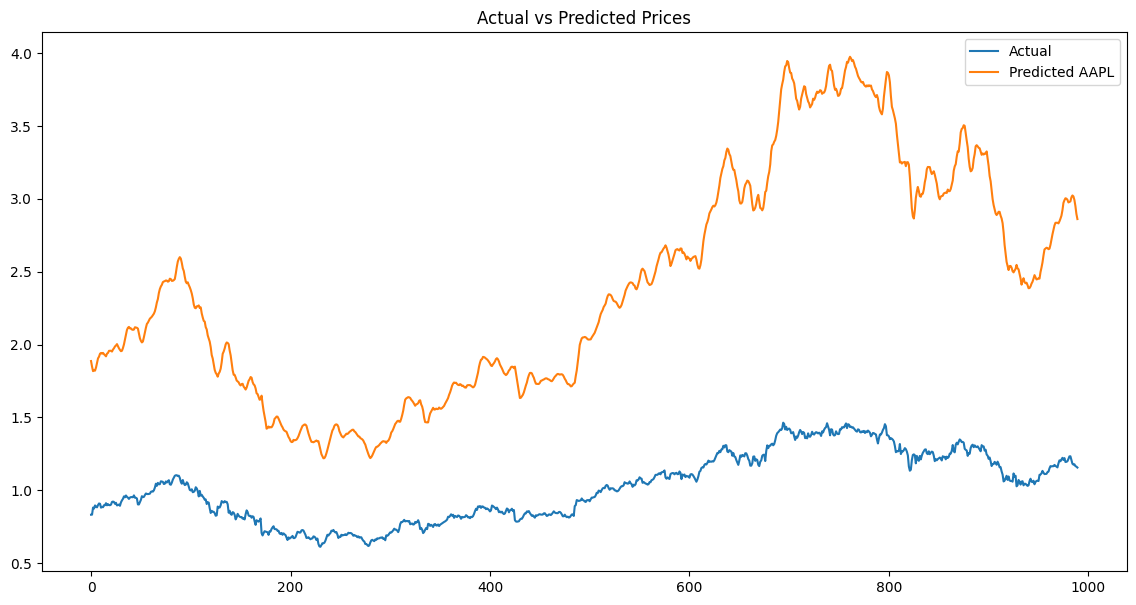

In [312]:
predictions_AAPL = model_LSTM.predict(x_val_AAPL)

plt.figure(figsize=(14, 7))
plt.plot(y_val_AAPL, label='Actual')
plt.plot(predictions_AAPL, label='Predicted AAPL')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


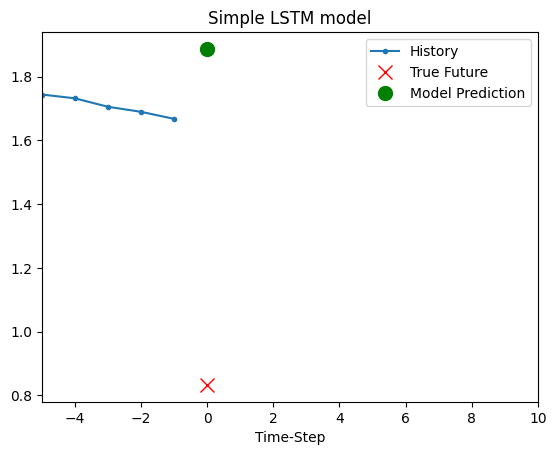

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


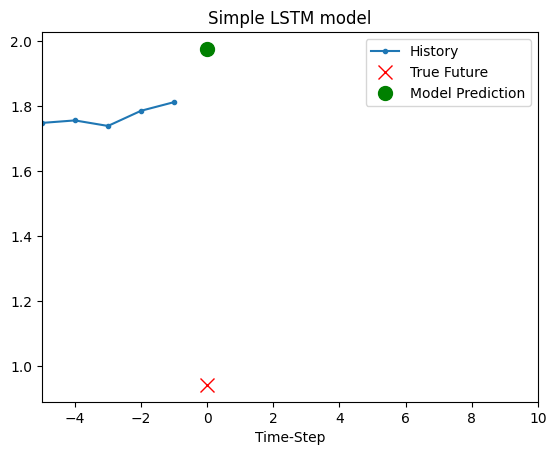

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


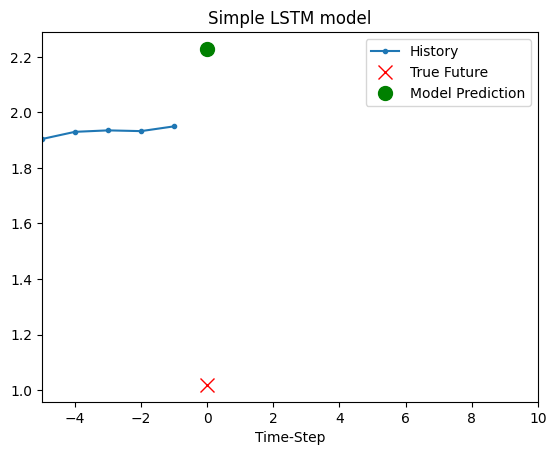

In [313]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

for x, y in val_univariate_AAPL.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model_LSTM.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### AMD Predict

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


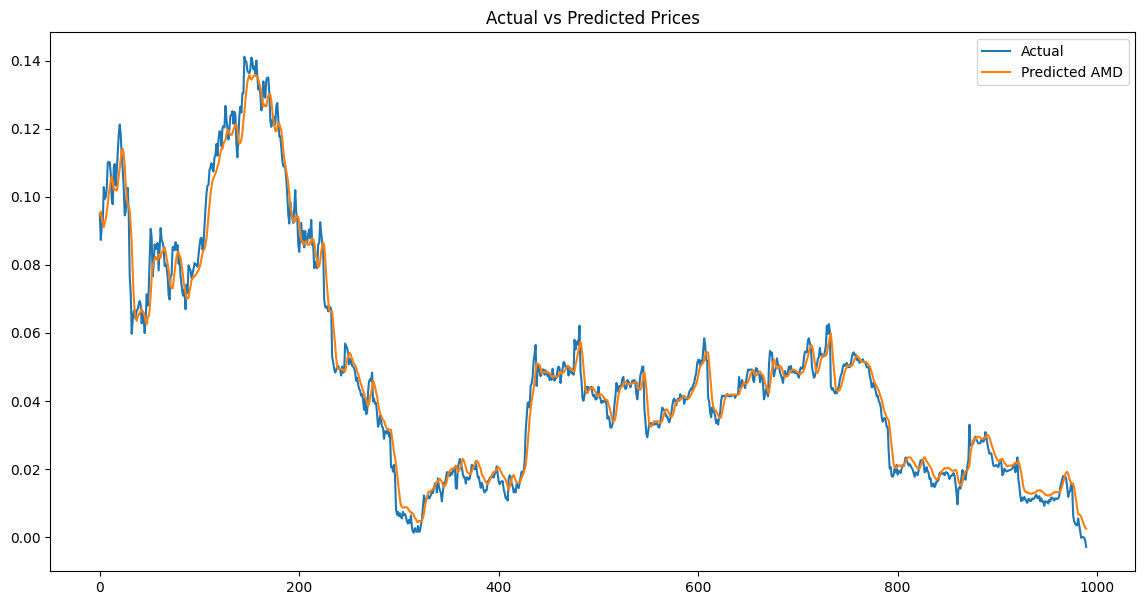

In [314]:
predictions_AMD = model_LSTM.predict(x_val_AMD)
plt.figure(figsize=(14, 7))
plt.plot(y_val_AMD, label='Actual')
plt.plot(predictions_AMD, label='Predicted AMD')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


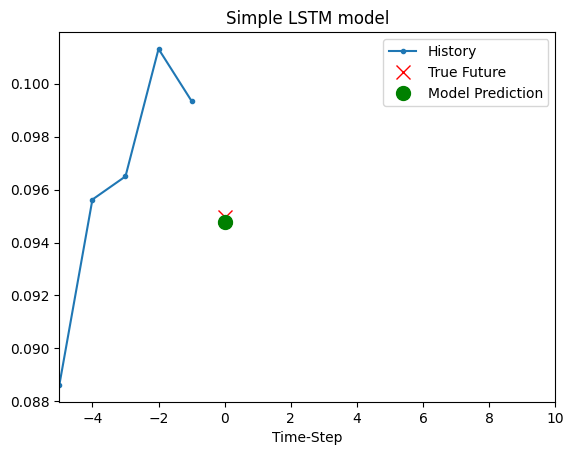

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


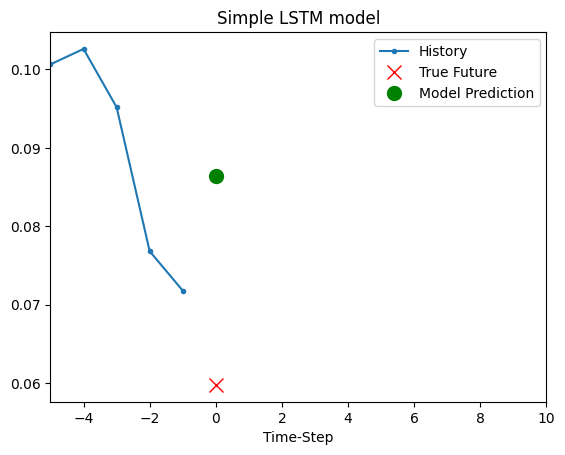

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


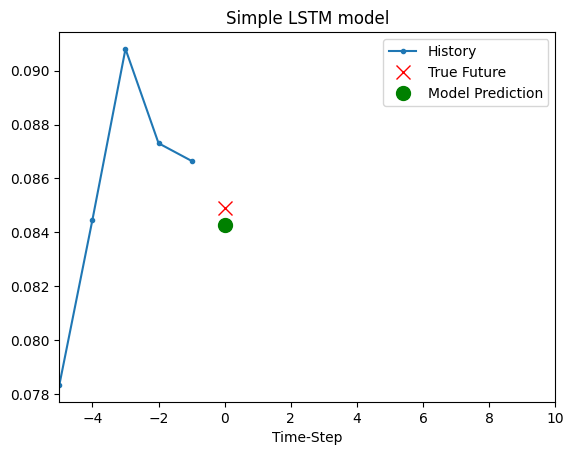

In [315]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

for x, y in val_univariate_AMD.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model_LSTM.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# **Model LSTM Modified**

In [316]:
model_LSTM_Mod = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_LSTM_Mod.compile(optimizer='adam', loss='mean_squared_error')

In [317]:
model_LSTM_Mod.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [318]:
model_LSTM_Mod.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
loss_AAPL, mae_AAPL = model_LSTM_Mod.evaluate(x_val_AAPL, y_val_AAPL, verbose=0)
loss_AMD, mae_AMD = model_LSTM_Mod.evaluate(x_val_AMD, y_val_AMD, verbose=0)
print(f'AAPL:\nLoss: {loss_AAPL}, Mean Absolute Error: {mae_AAPL}')
print(f'AMD:\nLoss: {loss_AMD}, Mean Absolute Error: {mae_AMD}')

AAPL:
Loss: 1.1836378574371338, Mean Absolute Error: 1.060880422592163
AMD:
Loss: 0.0035048413556069136, Mean Absolute Error: 0.048656463623046875


### AAPL Predict (Mod)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


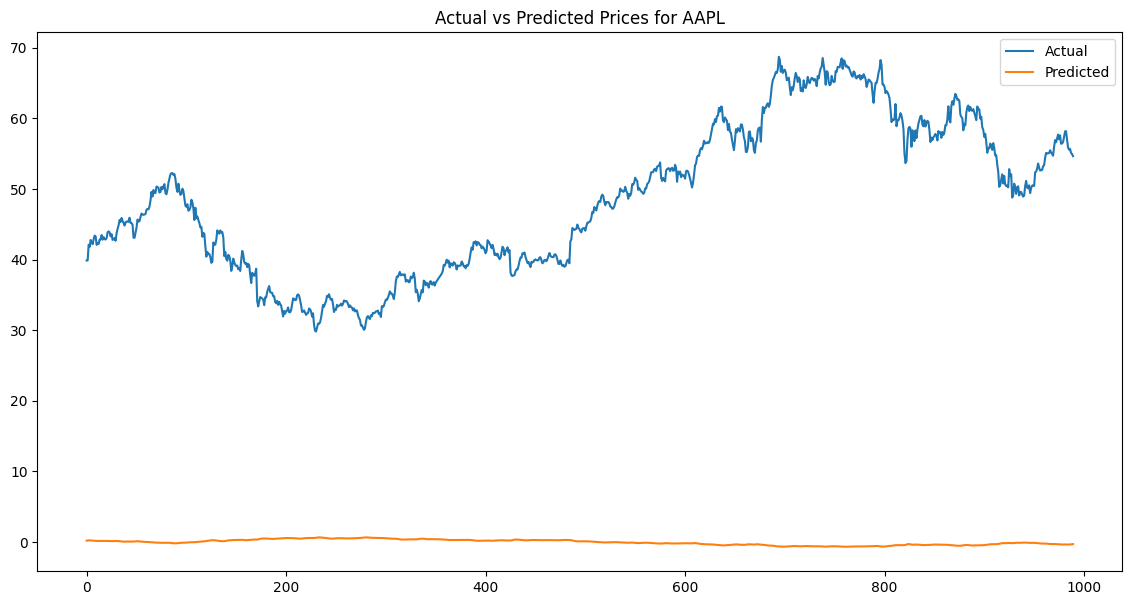

In [319]:
predictions = model_LSTM_Mod.predict(x_val_AAPL)

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(y_val_AAPL), label='Actual')
plt.plot(scaler.inverse_transform(predictions), label='Predicted')
plt.title('Actual vs Predicted Prices for AAPL')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


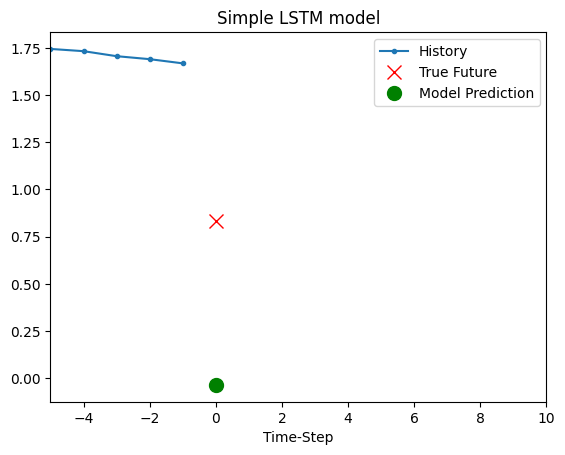

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


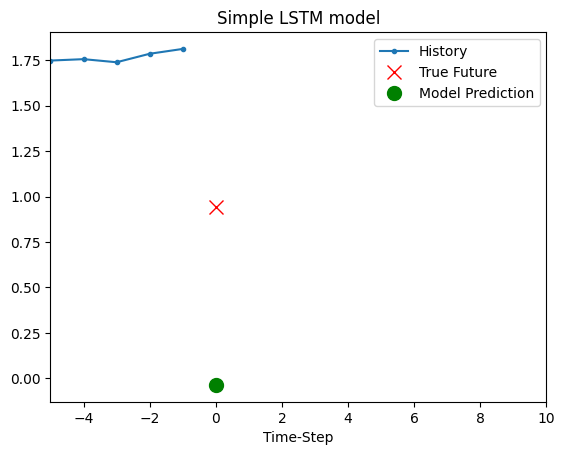

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


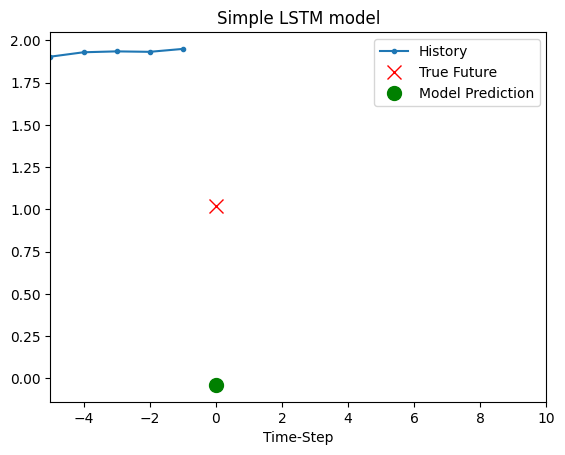

In [320]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

for x, y in val_univariate_AAPL.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model_LSTM_Mod.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### AMD Predict (Mod)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


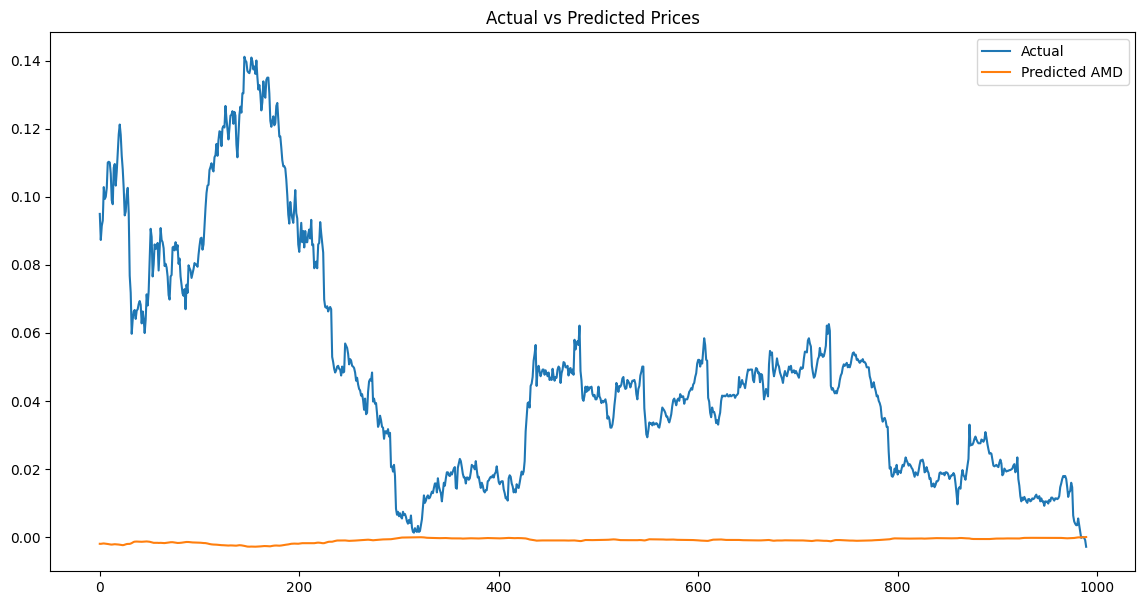

In [321]:
predictions_AMD = model_LSTM_Mod.predict(x_val_AMD)
plt.figure(figsize=(14, 7))
plt.plot(y_val_AMD, label='Actual')
plt.plot(predictions_AMD, label='Predicted AMD')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


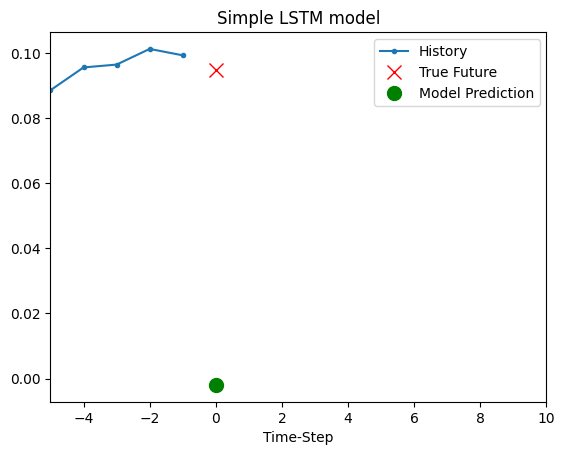

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


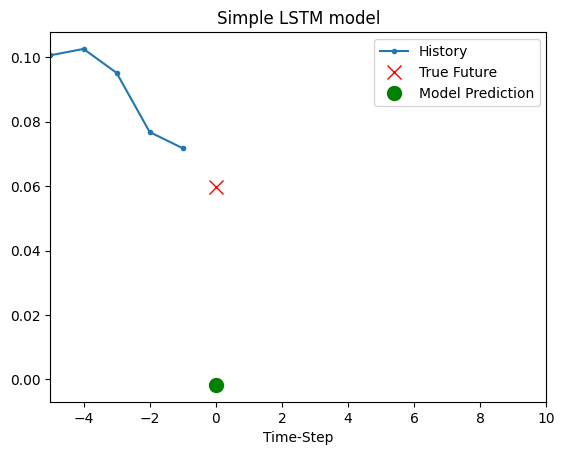

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


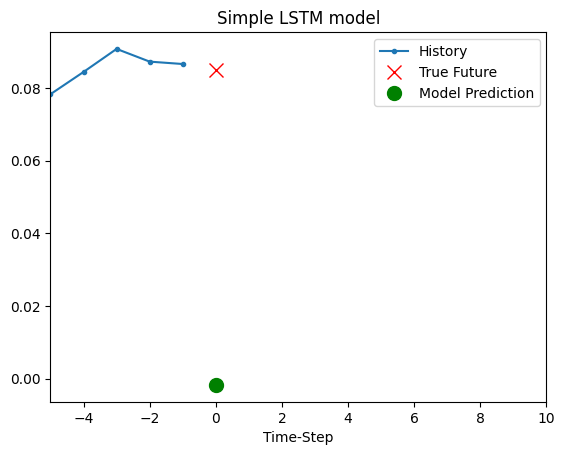

In [322]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

for x, y in val_univariate_AMD.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model_LSTM_Mod.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# **Evaluasi kedua model**

In [325]:
predictions_simple_AAPL = model_LSTM.predict(x_test_AAPL)
predictions_Modified_AAPL = model_LSTM_Mod.predict(x_test_AAPL)

rmse_simple_AAPL, mae_simple_AAPL, mape_simple_AAPL = evaluate_metrics(y_test_AAPL, predictions_simple_AAPL)
rmse_Modified_AAPL, mae_Modified_AAPL, mape_Modified_AAPL = evaluate_metrics(y_test_AAPL, predictions_Modified_AAPL)

print(f"(AAPL) Simple LSTM Model:")
print(f"RMSE: {rmse_simple_AAPL:.4f}")
print(f"MAE: {mae_simple_AAPL:.4f}")
print(f"MAPE: {mape_simple_AAPL:.4f}%\n")

print(f"(AAPL) LSTM Model (Modified):")
print(f"RMSE: {rmse_Modified_AAPL:.4f}")
print(f"MAE: {mae_Modified_AAPL:.4f}")
print(f"MAPE: {mape_Modified_AAPL:.4f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(AAPL) Simple LSTM Model:
RMSE: 5.9859
MAE: 5.0600
MAPE: 238.7149%

(AAPL) LSTM Model (Modified):
RMSE: 2.0857
MAE: 2.0020
MAPE: 103.2969%


In [326]:
predictions_simple_AMD = model_LSTM.predict(x_test_AMD)
predictions_Modified_AMD = model_LSTM_Mod.predict(x_test_AMD)

rmse_simple_AMD, mae_simple_AMD, mape_simple_AMD = evaluate_metrics(y_test_AMD, predictions_simple_AMD)
rmse_Modified_AMD, mae_Modified_AMD, mape_Modified_AMD = evaluate_metrics(y_test_AMD, predictions_Modified_AMD)

print(f"(AMD) Simple LSTM Model:")
print(f"RMSE: {rmse_simple_AMD:.4f}")
print(f"MAE: {mae_simple_AMD:.4f}")
print(f"MAPE: {mape_simple_AMD:.4f}%\n")

print(f"(AMD) LSTM Model (Modified):")
print(f"RMSE: {rmse_Modified_AMD:.4f}")
print(f"MAE: {mae_Modified_AMD:.4f}")
print(f"MAPE: {mape_Modified_AMD:.4f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(AMD) Simple LSTM Model:
RMSE: 0.0277
MAE: 0.0171
MAPE: inf%

(AMD) LSTM Model (Modified):
RMSE: 0.4348
MAE: 0.3301
MAPE: inf%


### AAPL - Simple LSTM Model vs. LSTM Model (Modified):
- **RMSE dan MAE**: Terlihat bahwa LSTM Model (Modified) memiliki nilai RMSE (2.0857) dan MAE (2.0020) yang lebih rendah dibandingkan dengan Simple LSTM Model (RMSE: 5.9859, MAE: 5.0600). Hal ini menunjukkan bahwa model yang dimodifikasi memberikan prediksi yang lebih dekat dengan nilai aktual, dengan kesalahan yang lebih rendah.
- **MAPE**: Meskipun MAPE untuk LSTM Model (Modified) (103.2969%) masih tinggi, perbaikan signifikan dari nilai Simple LSTM Model (238.7149%) menunjukkan peningkatan kualitas prediksi relatif.


### AMD - Simple LSTM Model vs. LSTM Model (Modified):
- **RMSE dan MAE**: Sama seperti pada kasus AAPL, LSTM Model (Modified) untuk AMD memiliki RMSE (0.4348) dan MAE (0.3301) yang lebih rendah dibandingkan dengan Simple LSTM Model (RMSE: 0.0277, MAE: 0.0171). Ini menunjukkan peningkatan kinerja model dalam memprediksi harga saham AMD.
- **MAPE**: Meskipun MAPE tidak bisa dihitung untuk kedua model AMD karena nilai aktual yang sangat kecil atau nol, perbaikan pada RMSE dan MAE menunjukkan bahwa LSTM Model (Modified) memberikan prediksi yang lebih akurat.
### Kesimpulan:
Berdasarkan hasil evaluasi ini, LSTM Model (Modified) lebih baik daripada Simple LSTM Model untuk kedua saham AAPL dan AMD. Hal ini ditunjukkan oleh penurunan signifikan dalam RMSE dan MAE, yang menandakan bahwa model yang dimodifikasi mampu memberikan prediksi yang lebih akurat dan mendekati nilai aktual.